In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
file_path = '../data/data-reduced-train.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

,FIPS,State,County,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
0,17027,Illinois,Clinton,8.7,16.7,34.8,9.0,25.8,63.809317,18.658612,...,18.662115,3.243111,0.403696,0.655667,0.083990,3.541142,91.007613,0.535157,47.787802,80.216266
1,42071,Pennsylvania,Lancaster,8.2,16.7,35.2,8.8,23.4,80.948635,17.168046,...,19.735587,3.722587,0.474823,2.778152,0.114798,11.589407,80.193630,2.150077,50.747266,27.875490
2,46003,South Dakota,Aurora,8.2,17.0,38.8,7.8,23.1,3.349108,21.089477,...,21.125227,0.907441,2.903811,0.943739,0.000000,8.457350,85.880218,1.615576,48.566243,100.000000
3,46027,South Dakota,Clay,9.2,16.3,35.6,7.6,22.2,85.568250,22.062377,...,12.624346,1.760471,4.011780,2.729058,0.065445,3.331152,86.302356,0.406533,50.425393,22.101958
4,13205,Georgia,Mitchell,15.9,22.8,42.2,6.8,34.5,59.917260,13.354151,...,18.407842,45.870430,0.672476,0.975564,0.066300,5.479257,46.126160,0.725704,49.720591,75.775684


### Get basic info on median house income feature
Here is a heat map with Income data by counties https://www.census.gov/library/visualizations/interactive/median-household-income.html

In [4]:
data['Median Household Income'].describe()

count      2513.000000
mean      63367.031437
std       16377.967261
min       28972.000000
25%       52483.000000
50%       60907.000000
75%       70594.000000
max      167605.000000
Name: Median Household Income, dtype: float64

### Split the DataFrame into two based on the median (set this up so it can be done for any feature)

In [29]:
#feature = 'Median Household Income'
feature = '% Non-Hispanic White'
median_feature = data[feature].median()
feature_bottom_50 = data[data[feature] <= median_feature]
feature_top_50 = data[data[feature] > median_feature]

In [30]:
feature_bottom_50.head()

,FIPS,State,County,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
1,42071,Pennsylvania,Lancaster,8.2,16.7,35.2,8.8,23.4,80.948635,17.168046,...,19.735587,3.722587,0.474823,2.778152,0.114798,11.589407,80.193630,2.150077,50.747266,27.875490
4,13205,Georgia,Mitchell,15.9,22.8,42.2,6.8,34.5,59.917260,13.354151,...,18.407842,45.870430,0.672476,0.975564,0.066300,5.479257,46.126160,0.725704,49.720591,75.775684
6,40111,Oklahoma,Okmulgee,12.8,23.4,42.8,6.0,33.0,58.848690,13.303774,...,18.618546,7.680454,17.134361,0.692079,0.072993,5.047310,61.208435,0.344867,50.213571,53.078516
9,6023,California,Humboldt,10.1,15.6,33.2,7.4,20.0,88.949386,18.962154,...,19.989630,1.285831,6.418784,3.113843,0.373306,13.225687,72.056885,1.722674,50.420710,31.534555
11,35009,New Mexico,Curry,11.4,17.7,34.6,6.7,25.9,72.985753,14.853221,...,13.601363,5.657241,2.398384,1.889254,0.256669,45.569301,44.035597,4.235860,48.388454,18.823044


In [31]:
%run ../data/features-grouped.ipynb #This has a "feature_list" and "features_by_category"
%run ../data/model-information.ipynb 

In [32]:
health_behaviors_features = features_by_category["Health Behaviors"]
access_to_care_features = features_by_category['Access to Care']
socio_economic_features = features_by_category['Socio-economic Factors']
physical_environment_features = features_by_category['Physical Environment']
demographics_features = features_by_category['Demographics']

In [33]:
def feature_importance(data):

    target = '% Adults with Diabetes'
    features = data.drop(columns=['FIPS', 'State', 'County', target, feature])  # Exclude identifier columns
    
    X = features
    y = data[target]
    
    # First, split into train + validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Then, split train + validation into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
    
    #Initialize and Train XGBoost with Cross-Validation
    #xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model = XGBRegressor(**xgb_best_params_full)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse_scores = (-cv_scores) ** 0.5  # Convert negative MSE to RMSE
    
    print("Cross-Validation RMSE Scores:", cv_rmse_scores)
    print("Average CV RMSE:", cv_rmse_scores.mean())
    
    #Train on Entire Train Set and Validate on the Validation Set
    xgb_model.fit(X_train, y_train)
    y_val_pred = xgb_model.predict(X_val)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    print(f"Validation RMSE: {val_rmse}")
    
    feature_importance = xgb_model.feature_importances_
    # sorted_idx = feature_importance.argsort()
    # sorted_features = X.columns[sorted_idx]
    # sorted_importance = feature_importance[sorted_idx]
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })
    importance_df = importance_df[importance_df['Feature'] != 'Median Household Income']
    
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)
    
    return(importance_df_sorted)

In [34]:
# category_colors = {
#     "Health Behaviors": "skyblue",
#     "Access to Care": "lightcoral",
#     "Socio-economic Factors": "gold",
#     "Physical Environment": "lightpink",
#     "Demographics": "lightseagreen"
# }

category_colors = {
    "Health Behaviors": "blue",
    "Access to Care": "green",
    "Socio-economic Factors": "orange",
    "Physical Environment": "purple",
    "Demographics": "brown",
}

feature_to_category = {}
for category, features in features_by_category.items():
    for feature in features:
        feature_to_category[feature] = category

Train set: (753, 47), Validation set: (252, 47), Test set: (252, 47)
Cross-Validation RMSE Scores: [0.5451628  0.59869927 0.62044699 0.62693425 0.62878553]
Average CV RMSE: 0.6040057688834367
Validation RMSE: 0.5743517600981205


/Users/chiara/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


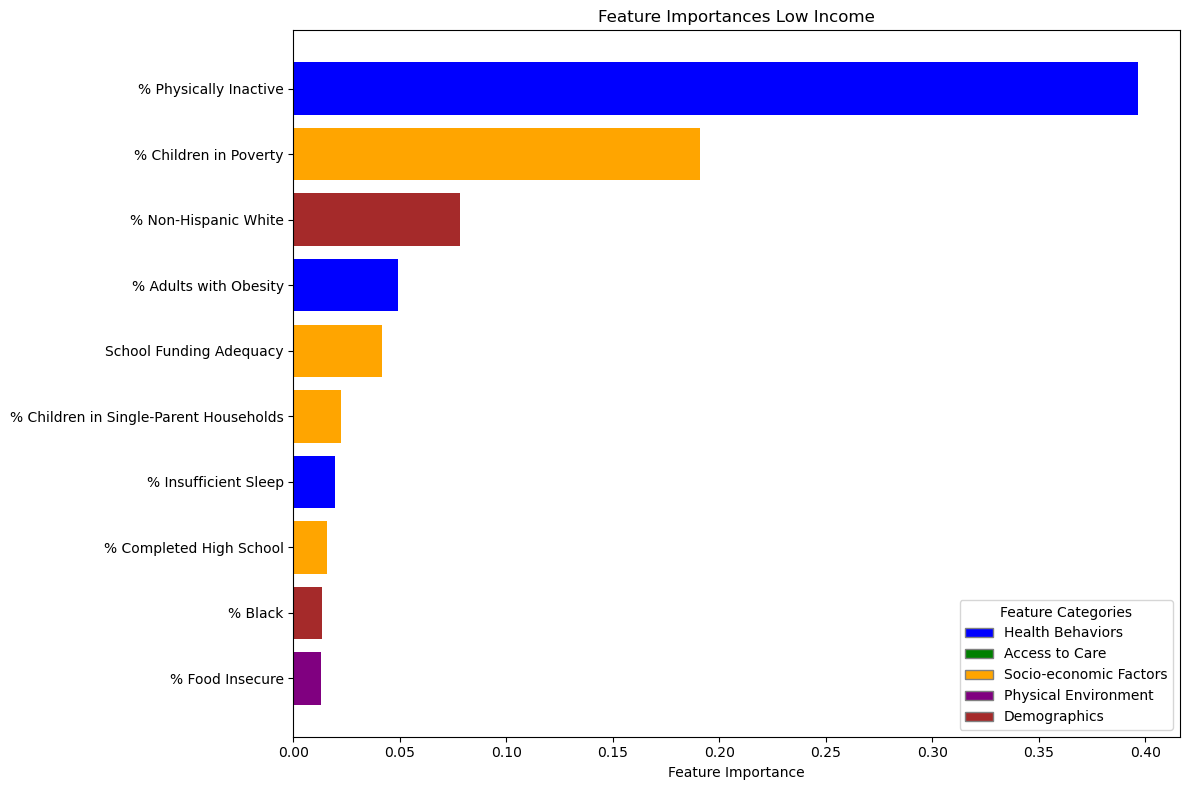

In [35]:
importance_bottom_50 = feature_importance(feature_bottom_50)

# Map each feature to its category
importance_bottom_50['Category'] = importance_bottom_50['Feature'].map(feature_to_category)

# Assign colors based on the mapped categories
importance_bottom_50['Color'] = importance_bottom_50['Category'].map(category_colors)

plt.figure(figsize=(12, 8)) 

# Number of top features to display
top_n = 10
top_features = importance_bottom_50.tail(top_n)['Feature'].values
top_importance = importance_bottom_50.tail(top_n)['Importance'].values
feature_colors_top = importance_bottom_50.tail(top_n)['Color'].values

bars = plt.barh(top_features, top_importance, color=feature_colors_top)

plt.xlabel('Feature Importance')
plt.title('Feature Importances Low Income')

# Create a legend for the categories
legend_elements = [
    Patch(facecolor=color, edgecolor='gray', label=category)
    for category, color in category_colors.items()
]

plt.legend(handles=legend_elements, title='Feature Categories', loc='lower right')
plt.tight_layout()
plt.show()

Train set: (753, 47), Validation set: (251, 47), Test set: (252, 47)
Cross-Validation RMSE Scores: [0.40366997 0.45829894 0.40221621 0.36996556 0.37771886]
Average CV RMSE: 0.4023739090110336
Validation RMSE: 0.4543679795952245


/Users/chiara/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


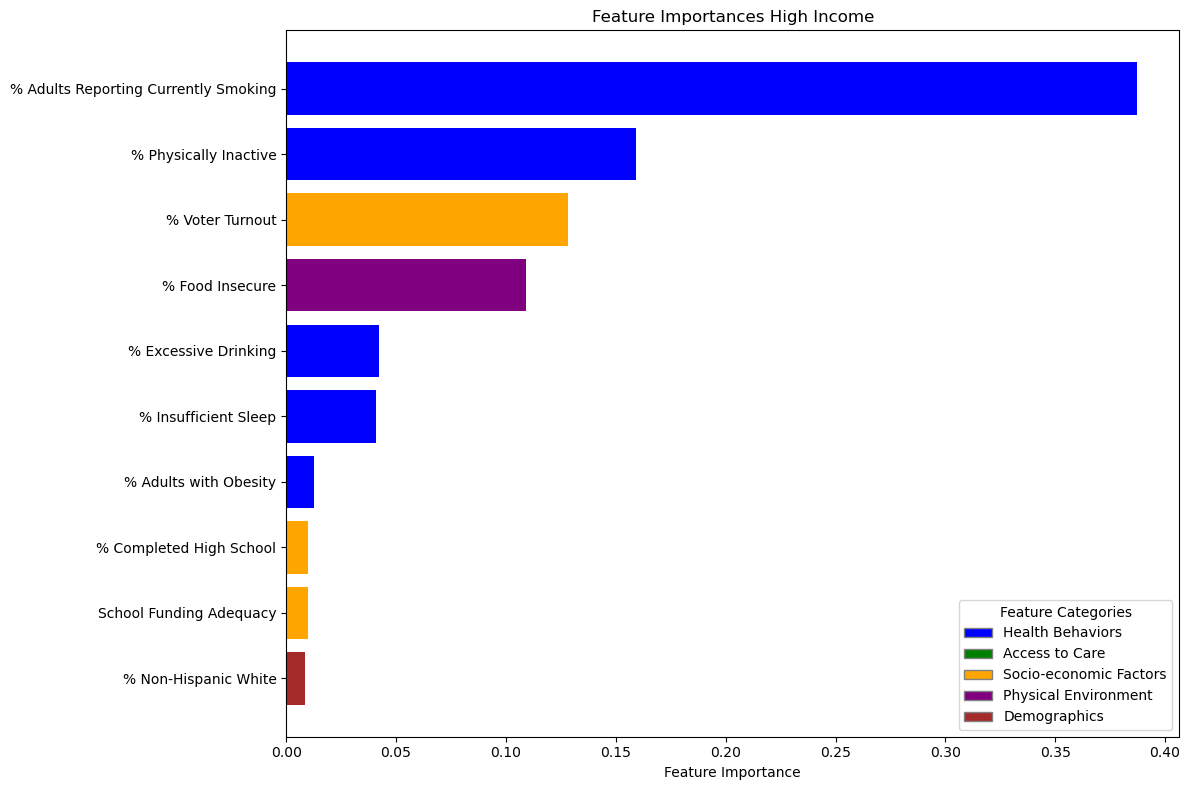

In [36]:
importance_top_50 = feature_importance(feature_top_50)

# Map each feature to its category
importance_top_50['Category'] = importance_top_50['Feature'].map(feature_to_category)

# Assign colors based on the mapped categories
importance_top_50['Color'] = importance_top_50['Category'].map(category_colors)

plt.figure(figsize=(12, 8)) 

# Number of top features to display
top_n = 10
top_features = importance_top_50.tail(top_n)['Feature'].values
top_importance = importance_top_50.tail(top_n)['Importance'].values
feature_colors_top = importance_top_50.tail(top_n)['Color'].values

bars = plt.barh(top_features, top_importance, color=feature_colors_top)

plt.xlabel('Feature Importance')
plt.title('Feature Importances High Income')

# Create a legend for the categories
legend_elements = [
    Patch(facecolor=color, edgecolor='gray', label=category)
    for category, color in category_colors.items()
]

plt.legend(handles=legend_elements, title='Feature Categories', loc='lower right')
plt.tight_layout()
plt.show()